In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import sys
import platform
import logging
import argparse
import trino
import io
import boto3
from itertools import islice
from datetime import datetime, date, timedelta
import pendulum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# Add parent directory to path
repo_path = '/Users/apple/Documents/naarni/repo/dview-naarni-data-platform'
sys.path.append(os.path.join(repo_path, 'tasks'))

# Import necessary files and its respective functions
from common.db_operations import connect_to_trino, fetch_data_for_day, write_df_to_iceberg,drop_table,execute_query
from common.optimizer_logic import optimize_dataframe_memory

# Import business logic functions
from biz_logic.energy_mileage.energy_mileage_daily_v0 import energy_mileage_stats ,impute_odometer_readings

from biz_logic.energy_consumption.energy_consumption_report import energy_consumption_stats

# Configure basic logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

# Print the Python version being used
print(f"Using Python version: {platform.python_version()}")

Using Python version: 3.13.7


In [3]:
# ---- reporting config (edit ONLY this) ----
TABLE_NAME = "can_parsed_output_100"   # <— change only this

# derived (don’t edit)
REPORT_TABLE = f"adhoc.facts_prod.{TABLE_NAME}"
REPORT_S3_LOCATION = f"s3a://naarni-data-lake/aqua/warehouse/facts_prod.db/{TABLE_NAME}/"

In [4]:
date_str = "2025-10-27"  # Date for which data is to be processed

# Parse the date string as a date object
target_date = datetime.strptime(date_str, "%Y-%m-%d").date()

# Create datetime objects for the start and end of the day in IST
ist_start = datetime.combine(target_date, datetime.min.time())
ist_end = ist_start + timedelta(days=1)

# Convert IST to UTC for the database query
# IST is UTC+5:30, so we subtract 5 hours and 30 minutes
utc_start = ist_start - timedelta(hours=5, minutes=30)
utc_end = ist_end - timedelta(hours=5, minutes=30)

logging.info(f"🔍 Query window (UTC): {utc_start} → {utc_end}")
logging.info(f"🔍 Query window (IST): {ist_start} → {ist_end}")

2025-11-04 10:19:57 - INFO - 🔍 Query window (UTC): 2025-10-26 18:30:00 → 2025-10-27 18:30:00
2025-11-04 10:19:57 - INFO - 🔍 Query window (IST): 2025-10-27 00:00:00 → 2025-10-28 00:00:00


### AC Fault Code:
1. No_Fault
2. Low_Voltage
3. Outside_Temp_Sensor_Fault
4. High_Voltage
5. Exhaust_Temp_Protection
6. Eva_Temp_Sesnor_Fault
7. AC Communication Fail

### AC Status:
1. Start
2. Stop

### TMS Fault Code:
1. No Fault
2. Water_Sensor_Failure
3. Water_Pump_Failure
4. Water_IN_Sensor_Failure
5. Exhaust_Temp_Protection
6. Low_Water_Level_Alarm
7. LV Undervoltage

### TMS Working Mode:
1. Charging_Cooling
2. Fast_Discharge_Cooling
3. Self_Circulation
4. Low_Coolant
5. Off

### B2T TMS Control Cmd:
1. Charging_Cooling
2. Fast_Discharge_Cooling
3. Self_Circulation
4. Off

In [5]:
# query = f"""
# select 
#     id,date(timestamp + interval '5:30' hour to minute) as dateval,count(*) 
# FROM 
#     facts_prod.can_parsed_output_100
# where 
#     id in ('6') and 
#     timestamp >= TIMESTAMP '{utc_start.strftime('%Y-%m-%d %H:%M:%S')}' and
#     timestamp < TIMESTAMP '{utc_end.strftime('%Y-%m-%d %H:%M:%S')}'
# group by 1,2"""

# conn = connect_to_trino(host="analytics.internal.naarni.com",port=443,user="admin",catalog="adhoc",schema="default")

# df = execute_query(conn, f"SELECT * FROM {REPORT_TABLE} LIMIT 5", return_results=True)
# display(df)

In [ ]:
def fetch_battery_data(start_date, end_date, vehicle_ids):
    """
    Fetch raw battery data from the database for the specified date range and vehicle IDs.
    
    Args:
        start_date: Start date in 'YYYY-MM-DD' format
        end_date: End date in 'YYYY-MM-DD' format
        vehicle_ids: List of vehicle IDs
        
    Returns:
        Tuple of (df_cpo100, df_can_ac) containing raw data from both tables
    """
    logging.info(f"Fetching raw battery data from {start_date} to {end_date} for vehicles {vehicle_ids}")
    
    # Format vehicle IDs for the query
    vehicle_ids_str = ', '.join([f"'{vid}'" for vid in vehicle_ids])
    
    # Connect to Trino
    conn = connect_to_trino(host="analytics.internal.naarni.com", port=443, user="admin", catalog="adhoc", schema="default")

    # Query for cpo100 data
    cpo100_query = f"""
    SELECT 
        id,timestamp,sequence,number_of_can_ids,number_of_records,percentage_of_can_ids,lowpressureoilpumpfaultcode,lowvoltagedcaclifesignal,batterycoolingstate,
        batterycoolanttemperature,odometerreading,brakepedalpos,ebsredwarningsignal,abs_ebsamberwarningsignal,insulation_status,insulation__value,lifesignalofinsulation,
        output_phase_voltage,output_phase_currant,motor_rpm,motor_torque,motor_temperature,igbt_temperature,mcuself_teststatus,side_door_panel_open_alarm,ignitionstatus,
        brakingsystemmallfunction_alarm,parking_brake_status,front_air_pressure,rear_air_pressure,brake_pad_worn_out_alarm,
        --charger_current, charger_voltage, chargingerror_bms, chrargecurrent_request, evcc_error, 
        guna_dcp_temperature,guna_dcm_temperature,gunb_dcp_temperature,gunb_dcm_temperature,--gunc_dcm_temperature, gunc_dcp_temperature,
        batterypackovervoltagealarm,monomerovervoltagealarm,polehightemperaturealarm,batteryhightemperaturealarm,hightempalarmofcharginggun,monomerundervoltagealarm,
        batterypackundervoltagealarm,temperaturedifferencealarm,singlevoltagedifferencealarm,chargingcurrentalarm,dischargecurrentalarm,sochighalarm,soclowalarm,
        bms_fault_code,gun_connection_status,maxavailableshorttermcharging,maxavailableshorttimedischarge,chargingcontactor2positive,chargingcontactor2negative,chargingcontactor1positive,
        batterytotalnegativecontactor,chargingcontactor1negative,pack_negative_contactors_status,bat_soc,bat_voltage,total_battery_current,bmslifesignal,steering_pump_enable_command,
        air_compressor_enable_command,dcdc_enable_command,vcuversioninformation,distancetoempty,accelarationpedal,brake_pedal,vcuself_teststatus,systeminterlockstate,vehiclereadycondition,
        vehicle_speed_vcu,gear_position,autoholdunenable,powertrain_failure_alarm,vcu_fault_code,vehiclecontrollerlife,
        --pack1_cellmax_voltagecellnumber,pack1_cell_max_voltage,pack1_cellminvoltagecellnumber,pack1_cell_min_voltage,th_management_sys_working_mode,
        cellmax_voltagecellnumber,cell_max_voltage,cellminvoltagecellnumber,cell_min_voltage,
        pack1_cellmax_temperature,pack1_maxtemperature_cell_number,pack1_cell_min_temperature,pack1_celltemperature_cellnumber,
        fourinonelifesignal,fourinoneself_teststatus,prechargedcontactorstate,mainmotorcontactor1state,accessorycontactorstatus,
        pre_charge_status,fiveinone_faultcode,airpumpcondition,air_compreesor_temperature,airpumpdcaclifesignal,
        dcdc_statusandfailure,dcdc_out_put_currant,dcdc_out_put_volatge,dcdcbusvoltage,dcdclifesignal,oilpumpcondition,steering_pump_rpm,steeringcontroller_failurealarm,
        pack_temperature1,pack_temperature2,pack_temperature3,pack_temperature4,pack_temperature5,pack_temperature6,pack_temperature7,pack_temperature8,pack_temperature9,pack_temperature10,
        pack_temperature11,pack_temperature12,pack_temperature13,pack_temperature14,pack_temperature15,pack_temperature16,pack_temperature17,pack_temperature18,pack_temperature19,pack_temperature20,
        pack_temperature21,pack_temperature22,pack_temperature23,pack_temperature24,pack_temperature25,pack_temperature26,pack_temperature27,pack_temperature28,pack_temperature29,pack_temperature30,
        pack_temperature31,pack_temperature32,pack_temperature33,pack_temperature34,pack_temperature35,pack_temperature36,pack_temperature37,pack_temperature38,pack_temperature39,pack_temperature40,
        pack_temperature41,pack_temperature42,pack_temperature43,pack_temperature44,pack_temperature45,pack_temperature46,pack_temperature47,pack_temperature48,pack_temperature49,pack_temperature50,
        pack_temperature51,pack_temperature52,pack_temperature53,pack_temperature54,pack_temperature55,pack_temperature56,pack_temperature57,pack_temperature58,pack_temperature59,pack_temperature60,
        pack_temperature61,pack_temperature62,pack_temperature63,pack_temperature64,pack_temperature65,pack_temperature66,pack_temperature67,pack_temperature68,pack_temperature69,pack_temperature70,
        pack_temperature71,pack_temperature72,pack_temperature73,pack_temperature74,pack_temperature75,pack_temperature76,pack_temperature77,pack_temperature78,pack_temperature79,pack_temperature80,
        --pack_temperature81,pack_temperature82,pack_temperature83,pack_temperature84,pack_temperature85,pack_temperature86,pack_temperature87,pack_temperature88,pack_temperature89,pack_temperature90,
        --pack_temperature91,pack_temperature92,pack_temperature93,pack_temperature94,pack_temperature95,pack_temperature96,pack_temperature97,pack_temperature98,pack_temperature99,pack_temperature100,
        --pack_temperature101,pack_temperature102,pack_temperature103,pack_temperature104,pack_temperature105,pack_temperature106,pack_temperature107,pack_temperature108,
        pack_cellvoltage_1,pack_cellvoltage_2,pack_cellvoltage_3,pack_cellvoltage_4,pack_cellvoltage_5,pack_cellvoltage_6,pack_cellvoltage_7,pack_cellvoltage_8,pack_cellvoltage_9,pack_cellvoltage_10,
        pack_cellvoltage_11,pack_cellvoltage_12,pack_cellvoltage_13,pack_cellvoltage_14,pack_cellvoltage_15,pack_cellvoltage_16,pack_cellvoltage_17,pack_cellvoltage_18,pack_cellvoltage_19,pack_cellvoltage_20,
        pack_cellvoltage_21,pack_cellvoltage_22,pack_cellvoltage_23,pack_cellvoltage_24,pack_cellvoltage_25,pack_cellvoltage_26,pack_cellvoltage_27,pack_cellvoltage_28,pack_cellvoltage_29,pack_cellvoltage_30,
        pack_cellvoltage_31,pack_cellvoltage_32,pack_cellvoltage_33,pack_cellvoltage_34,pack_cellvoltage_35,pack_cellvoltage_36,pack_cellvoltage_37,pack_cellvoltage_38,pack_cellvoltage_39,pack_cellvoltage_40,
        pack_cellvoltage_41,pack_cellvoltage_42,pack_cellvoltage_43,pack_cellvoltage_44,pack_cellvoltage_45,pack_cellvoltage_46,pack_cellvoltage_47,pack_cellvoltage_48,pack_cellvoltage_49,pack_cellvoltage_50,
        pack_cellvoltage_51,pack_cellvoltage_52,pack_cellvoltage_53,pack_cellvoltage_54,pack_cellvoltage_55,pack_cellvoltage_56,pack_cellvoltage_57,pack_cellvoltage_58,pack_cellvoltage_59,pack_cellvoltage_60,
        pack_cellvoltage_61,pack_cellvoltage_62,pack_cellvoltage_63,pack_cellvoltage_64,pack_cellvoltage_65,pack_cellvoltage_66,pack_cellvoltage_67,pack_cellvoltage_68,pack_cellvoltage_69,pack_cellvoltage_70,
        pack_cellvoltage_71,pack_cellvoltage_72,pack_cellvoltage_73,pack_cellvoltage_74,pack_cellvoltage_75,pack_cellvoltage_76,pack_cellvoltage_77,pack_cellvoltage_78,pack_cellvoltage_79,pack_cellvoltage_80,
        pack_cellvoltage_81,pack_cellvoltage_82,pack_cellvoltage_83,pack_cellvoltage_84,pack_cellvoltage_85,pack_cellvoltage_86,pack_cellvoltage_87,pack_cellvoltage_88,pack_cellvoltage_89,pack_cellvoltage_90,
        pack_cellvoltage_91,pack_cellvoltage_92,pack_cellvoltage_93,pack_cellvoltage_94,pack_cellvoltage_95,pack_cellvoltage_96,pack_cellvoltage_97,pack_cellvoltage_98,pack_cellvoltage_99,pack_cellvoltage_100,
        pack_cellvoltage_101,pack_cellvoltage_102,pack_cellvoltage_103,pack_cellvoltage_104,pack_cellvoltage_105,pack_cellvoltage_106,pack_cellvoltage_107,pack_cellvoltage_108,pack_cellvoltage_109,pack_cellvoltage_110,
        pack_cellvoltage_111,pack_cellvoltage_112,pack_cellvoltage_113,pack_cellvoltage_114,pack_cellvoltage_115,pack_cellvoltage_116,pack_cellvoltage_117,pack_cellvoltage_118,pack_cellvoltage_119,pack_cellvoltage_120,
        pack_cellvoltage_121,pack_cellvoltage_122,pack_cellvoltage_123,pack_cellvoltage_124,pack_cellvoltage_125,pack_cellvoltage_126,pack_cellvoltage_127,pack_cellvoltage_128,pack_cellvoltage_129,pack_cellvoltage_130,
        pack_cellvoltage_131,pack_cellvoltage_132,pack_cellvoltage_133,pack_cellvoltage_134,pack_cellvoltage_135,pack_cellvoltage_136,pack_cellvoltage_137,pack_cellvoltage_138,pack_cellvoltage_139,pack_cellvoltage_140,
        pack_cellvoltage_141,pack_cellvoltage_142,pack_cellvoltage_143,pack_cellvoltage_144,pack_cellvoltage_145,pack_cellvoltage_146,pack_cellvoltage_147,pack_cellvoltage_148,pack_cellvoltage_149,pack_cellvoltage_150,
        pack_cellvoltage_151,pack_cellvoltage_152,pack_cellvoltage_153,pack_cellvoltage_154,pack_cellvoltage_155,pack_cellvoltage_156,pack_cellvoltage_157,pack_cellvoltage_158,pack_cellvoltage_159,pack_cellvoltage_160,
        pack_cellvoltage_161,pack_cellvoltage_162,pack_cellvoltage_163,pack_cellvoltage_164,pack_cellvoltage_165,pack_cellvoltage_166,pack_cellvoltage_167,pack_cellvoltage_168,pack_cellvoltage_169,pack_cellvoltage_170,
        pack_cellvoltage_171,pack_cellvoltage_172,pack_cellvoltage_173,pack_cellvoltage_174,pack_cellvoltage_175,pack_cellvoltage_176,pack_cellvoltage_177,pack_cellvoltage_178,pack_cellvoltage_179,pack_cellvoltage_180,
        pack_cellvoltage_181,pack_cellvoltage_182,pack_cellvoltage_183,pack_cellvoltage_184,pack_cellvoltage_185,pack_cellvoltage_186,pack_cellvoltage_187,pack_cellvoltage_188,pack_cellvoltage_189,pack_cellvoltage_190,
        pack_cellvoltage_191,pack_cellvoltage_192,pack_cellvoltage_193,pack_cellvoltage_194,pack_cellvoltage_195,pack_cellvoltage_196,pack_cellvoltage_197,pack_cellvoltage_198,pack_cellvoltage_199,pack_cellvoltage_200,
        pack_cellvoltage_201,pack_cellvoltage_202,pack_cellvoltage_203,pack_cellvoltage_204,pack_cellvoltage_205,pack_cellvoltage_206,pack_cellvoltage_207,pack_cellvoltage_208,pack_cellvoltage_209,pack_cellvoltage_210,
        pack_cellvoltage_211,pack_cellvoltage_212,pack_cellvoltage_213,pack_cellvoltage_214,pack_cellvoltage_215,pack_cellvoltage_216,pack_cellvoltage_217,pack_cellvoltage_218,pack_cellvoltage_219,pack_cellvoltage_220,
        pack_cellvoltage_221,pack_cellvoltage_222,pack_cellvoltage_223,pack_cellvoltage_224,pack_cellvoltage_225,pack_cellvoltage_226,pack_cellvoltage_227,pack_cellvoltage_228,pack_cellvoltage_229,pack_cellvoltage_230,
        pack_cellvoltage_231,pack_cellvoltage_232,pack_cellvoltage_233,pack_cellvoltage_234,pack_cellvoltage_235,pack_cellvoltage_236,pack_cellvoltage_237,pack_cellvoltage_238,pack_cellvoltage_239,pack_cellvoltage_240,
        pack_cellvoltage_241,pack_cellvoltage_242,pack_cellvoltage_243,pack_cellvoltage_244,pack_cellvoltage_245,pack_cellvoltage_246,pack_cellvoltage_247,pack_cellvoltage_248,pack_cellvoltage_249,pack_cellvoltage_250,
        pack_cellvoltage_251,pack_cellvoltage_252,pack_cellvoltage_253,pack_cellvoltage_254,pack_cellvoltage_255,pack_cellvoltage_256,pack_cellvoltage_257,pack_cellvoltage_258,pack_cellvoltage_259,pack_cellvoltage_260,
        pack_cellvoltage_261,pack_cellvoltage_262,pack_cellvoltage_263,pack_cellvoltage_264,pack_cellvoltage_265,pack_cellvoltage_266,pack_cellvoltage_267,pack_cellvoltage_268,pack_cellvoltage_269,pack_cellvoltage_270,
        pack_cellvoltage_271,pack_cellvoltage_272,pack_cellvoltage_273,pack_cellvoltage_274,pack_cellvoltage_275,pack_cellvoltage_276,pack_cellvoltage_277,pack_cellvoltage_278,pack_cellvoltage_279,pack_cellvoltage_280,
        pack_cellvoltage_281,pack_cellvoltage_282,pack_cellvoltage_283,pack_cellvoltage_284,pack_cellvoltage_285,pack_cellvoltage_286,pack_cellvoltage_287,pack_cellvoltage_288,pack_cellvoltage_289,pack_cellvoltage_290,
        pack_cellvoltage_291,pack_cellvoltage_292,pack_cellvoltage_293,pack_cellvoltage_294,pack_cellvoltage_295,pack_cellvoltage_296,pack_cellvoltage_297,pack_cellvoltage_298,pack_cellvoltage_299,pack_cellvoltage_300,
        pack_cellvoltage_301,pack_cellvoltage_302,pack_cellvoltage_303,pack_cellvoltage_304,pack_cellvoltage_305,pack_cellvoltage_306,pack_cellvoltage_307,pack_cellvoltage_308,pack_cellvoltage_309,pack_cellvoltage_310,
        pack_cellvoltage_311,pack_cellvoltage_312,pack_cellvoltage_313,pack_cellvoltage_314,pack_cellvoltage_315,pack_cellvoltage_316,pack_cellvoltage_317,pack_cellvoltage_318,pack_cellvoltage_319,pack_cellvoltage_320,
        pack_cellvoltage_321,pack_cellvoltage_322,pack_cellvoltage_323,pack_cellvoltage_324,pack_cellvoltage_325,pack_cellvoltage_326,pack_cellvoltage_327,pack_cellvoltage_328,pack_cellvoltage_329,pack_cellvoltage_330,
        pack_cellvoltage_331,pack_cellvoltage_332,pack_cellvoltage_333,pack_cellvoltage_334,pack_cellvoltage_335,pack_cellvoltage_336,pack_cellvoltage_337,pack_cellvoltage_338,pack_cellvoltage_339,pack_cellvoltage_340,
        pack_cellvoltage_341,pack_cellvoltage_342,pack_cellvoltage_343,pack_cellvoltage_344,pack_cellvoltage_345,pack_cellvoltage_346,pack_cellvoltage_347,pack_cellvoltage_348,pack_cellvoltage_349,pack_cellvoltage_350,
        pack_cellvoltage_351,pack_cellvoltage_352,pack_cellvoltage_353,pack_cellvoltage_354,pack_cellvoltage_355,pack_cellvoltage_356,pack_cellvoltage_357,pack_cellvoltage_358,pack_cellvoltage_359,pack_cellvoltage_360,
        pack_cellvoltage_361,pack_cellvoltage_362,pack_cellvoltage_363,pack_cellvoltage_364,pack_cellvoltage_365,pack_cellvoltage_366,pack_cellvoltage_367,pack_cellvoltage_368,pack_cellvoltage_369,pack_cellvoltage_370,
        pack_cellvoltage_371,pack_cellvoltage_372,pack_cellvoltage_373,pack_cellvoltage_374,pack_cellvoltage_375,pack_cellvoltage_376,pack_cellvoltage_377,pack_cellvoltage_378,pack_cellvoltage_379,pack_cellvoltage_380
        pack_cellvoltage_381,pack_cellvoltage_382,pack_cellvoltage_383,pack_cellvoltage_384,pack_cellvoltage_385,pack_cellvoltage_386,pack_cellvoltage_387,pack_cellvoltage_388,pack_cellvoltage_389,pack_cellvoltage_390,
        pack_cellvoltage_391,pack_cellvoltage_392,pack_cellvoltage_393,pack_cellvoltage_394,pack_cellvoltage_395,pack_cellvoltage_396,pack_cellvoltage_397,pack_cellvoltage_398,pack_cellvoltage_399,pack_cellvoltage_400,
        pack_cellvoltage_401,pack_cellvoltage_402,pack_cellvoltage_403,pack_cellvoltage_404,pack_cellvoltage_405,pack_cellvoltage_406,pack_cellvoltage_407,pack_cellvoltage_408,pack_cellvoltage_409,pack_cellvoltage_410,
        pack_cellvoltage_411,pack_cellvoltage_412,pack_cellvoltage_413,pack_cellvoltage_414,pack_cellvoltage_415,pack_cellvoltage_416,pack_cellvoltage_417,pack_cellvoltage_418,pack_cellvoltage_419,pack_cellvoltage_420,
        pack_cellvoltage_421,pack_cellvoltage_422,pack_cellvoltage_423,pack_cellvoltage_424,pack_cellvoltage_425,pack_cellvoltage_426,pack_cellvoltage_427,pack_cellvoltage_428,pack_cellvoltage_429,pack_cellvoltage_430,
        pack_cellvoltage_431,pack_cellvoltage_432,pack_cellvoltage_433,pack_cellvoltage_434,pack_cellvoltage_435,pack_cellvoltage_436,pack_cellvoltage_437,pack_cellvoltage_438,pack_cellvoltage_439,pack_cellvoltage_440,
        pack_cellvoltage_441,pack_cellvoltage_442,pack_cellvoltage_443,pack_cellvoltage_444,pack_cellvoltage_445,pack_cellvoltage_446,pack_cellvoltage_447,pack_cellvoltage_448,pack_cellvoltage_449,pack_cellvoltage_450,
        pack_cellvoltage_451,pack_cellvoltage_452,pack_cellvoltage_453,pack_cellvoltage_454,pack_cellvoltage_455,pack_cellvoltage_456,pack_cellvoltage_457,pack_cellvoltage_458,pack_cellvoltage_459,pack_cellvoltage_460,
        pack_cellvoltage_461,pack_cellvoltage_462,pack_cellvoltage_463,pack_cellvoltage_464,pack_cellvoltage_465,pack_cellvoltage_466,pack_cellvoltage_467,pack_cellvoltage_468,pack_cellvoltage_469,pack_cellvoltage_470,
        pack_cellvoltage_471,pack_cellvoltage_472,pack_cellvoltage_473,pack_cellvoltage_474,pack_cellvoltage_475,pack_cellvoltage_476,pack_cellvoltage_477,pack_cellvoltage_478,pack_cellvoltage_479,pack_cellvoltage_480,
        pack_cellvoltage_481,pack_cellvoltage_482,pack_cellvoltage_483,pack_cellvoltage_484,pack_cellvoltage_485,pack_cellvoltage_486,pack_cellvoltage_487,pack_cellvoltage_488,pack_cellvoltage_489,pack_cellvoltage_490,
        pack_cellvoltage_491,pack_cellvoltage_492,pack_cellvoltage_493,pack_cellvoltage_494,pack_cellvoltage_495,pack_cellvoltage_496,pack_cellvoltage_497,pack_cellvoltage_498,pack_cellvoltage_499,pack_cellvoltage_500,
        pack_cellvoltage_501,pack_cellvoltage_502,pack_cellvoltage_503,pack_cellvoltage_504,pack_cellvoltage_505,pack_cellvoltage_506,pack_cellvoltage_507,pack_cellvoltage_508,pack_cellvoltage_509,pack_cellvoltage_510,
        pack_cellvoltage_511,pack_cellvoltage_512,pack_cellvoltage_513,pack_cellvoltage_514,pack_cellvoltage_515,pack_cellvoltage_516,pack_cellvoltage_517,pack_cellvoltage_518,pack_cellvoltage_519,pack_cellvoltage_520,
        pack_cellvoltage_521,pack_cellvoltage_522,pack_cellvoltage_523,pack_cellvoltage_524,pack_cellvoltage_525,pack_cellvoltage_526,pack_cellvoltage_527,pack_cellvoltage_528,pack_cellvoltage_529,pack_cellvoltage_530,
        pack_cellvoltage_531,pack_cellvoltage_532,pack_cellvoltage_533,pack_cellvoltage_534,pack_cellvoltage_535,pack_cellvoltage_536,pack_cellvoltage_537,pack_cellvoltage_538,pack_cellvoltage_539,pack_cellvoltage_540,
        pack_cellvoltage_541,pack_cellvoltage_542,pack_cellvoltage_543,pack_cellvoltage_544,pack_cellvoltage_545,pack_cellvoltage_546,pack_cellvoltage_547,pack_cellvoltage_548,pack_cellvoltage_549,pack_cellvoltage_550,
        pack_cellvoltage_551,pack_cellvoltage_552,pack_cellvoltage_553,pack_cellvoltage_554,pack_cellvoltage_555,pack_cellvoltage_556,pack_cellvoltage_557,pack_cellvoltage_558,pack_cellvoltage_559,pack_cellvoltage_560,
        pack_cellvoltage_561,pack_cellvoltage_562,pack_cellvoltage_563,pack_cellvoltage_564,pack_cellvoltage_565,pack_cellvoltage_566,pack_cellvoltage_567,pack_cellvoltage_568,pack_cellvoltage_569,pack_cellvoltage_570,
        pack_cellvoltage_571,pack_cellvoltage_572,pack_cellvoltage_573,pack_cellvoltage_574,pack_cellvoltage_575,pack_cellvoltage_576       
    FROM 
        --clickhouse.naarni.temp1
        facts_prod.can_parsed_output_100
    WHERE 
        --id = cast({vehicle_ids_str} as varbinary)
        --AND DATE(timestamp AT TIME ZONE 'Asia/Kolkata') = date('2025-10-01')
        id in ({vehicle_ids_str})
        and date(timestamp AT TIME ZONE 'Asia/Kolkata') between DATE('{start_date}') AND DATE('{end_date}')
    """
# between DATE('{start_date}') AND DATE('{end_date}')
    # Execute queries and fetch data
    cur = conn.cursor()

    # Fetch cpo100 data
    cur.execute(cpo100_query)
    cpo100_columns = [desc[0] for desc in cur.description]
    cpo100_rows = cur.fetchall()
    df_cpo100 = pd.DataFrame(cpo100_rows, columns=cpo100_columns)

    logging.info(f"Done Fetching data.")
    logging.info(f"Retrieved {len(df_cpo100)} cpo100 records from the database.")
    
    # Close connections
    cur.close()
    conn.close()
    
    return df_cpo100

In [7]:
def get_all_battery_data(start_date, end_date, vehicle_ids):
    """
    Fetch and process all battery data for the specified date range and vehicle IDs.
    
    Args:
        start_date: Start date in 'YYYY-MM-DD' format
        end_date: End date in 'YYYY-MM-DD' format
        vehicle_ids: List of vehicle IDs
        
    Returns:
        DataFrame with battery data
    """
    # Fetch raw data
    df_cpo100 = fetch_battery_data(start_date, end_date, vehicle_ids)
    
    # Process the data
    # result_df, df_cpo100_processed, df_can_ac_processed = process_battery_data(df_cpo100, df_can_ac)

    return df_cpo100

In [8]:
df_cpo100 = get_all_battery_data('2025-10-01', '2025-10-02', ['6'])

2025-11-04 10:19:57 - INFO - Fetching raw battery data from 2025-10-01 to 2025-10-02 for vehicles ['6']
2025-11-04 10:19:57 - INFO - 🔌 STEP 1: Connecting to Trino...
2025-11-04 10:19:57 - INFO - ✅ STEP 1: Connected to Trino
2025-11-04 10:23:20 - INFO - Done Fetching data.
2025-11-04 10:23:20 - INFO - Retrieved 115875 cpo100 records from the database.


In [9]:
display(df_cpo100.head(10))

,id,timestamp,sequence,number_of_can_ids,number_of_records,percentage_of_can_ids,lowpressureoilpumpfaultcode,lowvoltagedcaclifesignal,batterycoolingstate,batterycoolanttemperature,odometerreading,brakepedalpos,ebsredwarningsignal,abs_ebsamberwarningsignal,insulation_status,insulation__value,lifesignalofinsulation,output_phase_voltage,output_phase_currant,motor_rpm,motor_torque,motor_temperature,igbt_temperature,mcuself_teststatus,side_door_panel_open_alarm,ignitionstatus,brakingsystemmallfunction_alarm,parking_brake_status,front_air_pressure,rear_air_pressure,brake_pad_worn_out_alarm,guna_dcp_temperature,guna_dcm_temperature,gunb_dcp_temperature,gunb_dcm_temperature,batterypackovervoltagealarm,monomerovervoltagealarm,polehightemperaturealarm,batteryhightemperaturealarm,hightempalarmofcharginggun,monomerundervoltagealarm,batterypackundervoltagealarm,temperaturedifferencealarm,singlevoltagedifferencealarm,chargingcurrentalarm,dischargecurrentalarm,sochighalarm,soclowalarm,bms_fault_code,gun_connection_status,maxavailableshorttermcharging,maxavailableshorttimedischarge,chargingcontactor2positive,chargingcontactor2negative,chargingcontactor1positive,batterytotalnegativecontactor,chargingcontactor1negative,pack_negative_contactors_status,bat_soc,bat_voltage,total_battery_current,bmslifesignal,steering_pump_enable_command,air_compressor_enable_command,dcdc_enable_command,vcuversioninformation,distancetoempty,accelarationpedal,brake_pedal,vcuself_teststatus,systeminterlockstate,vehiclereadycondition,vehicle_speed_vcu,gear_position,autoholdunenable,powertrain_failure_alarm,vcu_fault_code,vehiclecontrollerlife,cellmax_voltagecellnumber,cell_max_voltage,cellminvoltagecellnumber,cell_min_voltage,pack1_cellmax_temperature,pack1_maxtemperature_cell_number,pack1_cell_min_temperature,pack1_celltemperature_cellnumber,fourinonelifesignal,fourinoneself_teststatus,prechargedcontactorstate,mainmotorcontactor1state,accessorycontactorstatus,pre_charge_status,fiveinone_faultcode,airpumpcondition,air_compreesor_temperature,airpumpdcaclifesignal,dcdc_statusandfailure,dcdc_out_put_currant,dcdc_out_put_volatge,dcdcbusvoltage,dcdclifesignal,oilpumpcondition,steering_pump_rpm,steeringcontroller_failurealarm,pack_temperature1,pack_temperature2,pack_temperature3,pack_temperature4,pack_temperature5,pack_temperature6,pack_temperature7,pack_temperature8,pack_temperature9,pack_temperature10,pack_temperature11,pack_temperature12,pack_temperature13,pack_temperature14,pack_temperature15,pack_temperature16,pack_temperature17,pack_temperature18,pack_temperature19,pack_temperature20,pack_temperature21,pack_temperature22,pack_temperature23,pack_temperature24,pack_temperature25,pack_temperature26,pack_temperature27,pack_temperature28,pack_temperature29,pack_temperature30,pack_temperature31,pack_temperature32,pack_temperature33,pack_temperature34,pack_temperature35,pack_temperature36,pack_temperature37,pack_temperature38,pack_temperature39,pack_temperature40,pack_temperature41,pack_temperature42,pack_temperature43,pack_temperature44,pack_temperature45,pack_temperature46,pack_temperature47,pack_temperature48,pack_temperature49,pack_temperature50,pack_temperature51,pack_temperature52,pack_temperature53,pack_temperature54,pack_temperature55,pack_temperature56,pack_temperature57,pack_temperature58,pack_temperature59,pack_temperature60,pack_temperature61,pack_temperature62,pack_temperature63,pack_temperature64,pack_temperature65,pack_temperature66,pack_temperature67,pack_temperature68,pack_temperature69,pack_temperature70,pack_temperature71,pack_temperature72,pack_temperature73,pack_temperature74,pack_temperature75,pack_temperature76,pack_temperature77,pack_temperature78,pack_temperature79,pack_temperature80,pack_cellvoltage_1,pack_cellvoltage_2,pack_cellvoltage_3,pack_cellvoltage_4,pack_cellvoltage_5,pack_cellvoltage_6,pack_cellvoltage_7,pack_cellvoltage_8,pack_cellvoltage_9,pack_cellvoltage_10,pack_cellvoltage_11,pack_cellvoltage_12,pack_cellvoltage_13,pack_cellvoltage_14,

In [10]:
df_cpo100.lowvoltagedcaclifesignal.describe()

count    97198.000000
mean       127.461758
std         73.970545
min          0.000000
25%         63.000000
50%        127.000000
75%        192.000000
max        255.000000
Name: lowvoltagedcaclifesignal, dtype: float64

In [11]:
df_cpo100[df_cpo100["vehiclereadycondition"]==1].head(10)

,id,timestamp,sequence,number_of_can_ids,number_of_records,percentage_of_can_ids,lowpressureoilpumpfaultcode,lowvoltagedcaclifesignal,batterycoolingstate,batterycoolanttemperature,odometerreading,brakepedalpos,ebsredwarningsignal,abs_ebsamberwarningsignal,insulation_status,insulation__value,lifesignalofinsulation,output_phase_voltage,output_phase_currant,motor_rpm,motor_torque,motor_temperature,igbt_temperature,mcuself_teststatus,side_door_panel_open_alarm,ignitionstatus,brakingsystemmallfunction_alarm,parking_brake_status,front_air_pressure,rear_air_pressure,brake_pad_worn_out_alarm,guna_dcp_temperature,guna_dcm_temperature,gunb_dcp_temperature,gunb_dcm_temperature,batterypackovervoltagealarm,monomerovervoltagealarm,polehightemperaturealarm,batteryhightemperaturealarm,hightempalarmofcharginggun,monomerundervoltagealarm,batterypackundervoltagealarm,temperaturedifferencealarm,singlevoltagedifferencealarm,chargingcurrentalarm,dischargecurrentalarm,sochighalarm,soclowalarm,bms_fault_code,gun_connection_status,maxavailableshorttermcharging,maxavailableshorttimedischarge,chargingcontactor2positive,chargingcontactor2negative,chargingcontactor1positive,batterytotalnegativecontactor,chargingcontactor1negative,pack_negative_contactors_status,bat_soc,bat_voltage,total_battery_current,bmslifesignal,steering_pump_enable_command,air_compressor_enable_command,dcdc_enable_command,vcuversioninformation,distancetoempty,accelarationpedal,brake_pedal,vcuself_teststatus,systeminterlockstate,vehiclereadycondition,vehicle_speed_vcu,gear_position,autoholdunenable,powertrain_failure_alarm,vcu_fault_code,vehiclecontrollerlife,cellmax_voltagecellnumber,cell_max_voltage,cellminvoltagecellnumber,cell_min_voltage,pack1_cellmax_temperature,pack1_maxtemperature_cell_number,pack1_cell_min_temperature,pack1_celltemperature_cellnumber,fourinonelifesignal,fourinoneself_teststatus,prechargedcontactorstate,mainmotorcontactor1state,accessorycontactorstatus,pre_charge_status,fiveinone_faultcode,airpumpcondition,air_compreesor_temperature,airpumpdcaclifesignal,dcdc_statusandfailure,dcdc_out_put_currant,dcdc_out_put_volatge,dcdcbusvoltage,dcdclifesignal,oilpumpcondition,steering_pump_rpm,steeringcontroller_failurealarm,pack_temperature1,pack_temperature2,pack_temperature3,pack_temperature4,pack_temperature5,pack_temperature6,pack_temperature7,pack_temperature8,pack_temperature9,pack_temperature10,pack_temperature11,pack_temperature12,pack_temperature13,pack_temperature14,pack_temperature15,pack_temperature16,pack_temperature17,pack_temperature18,pack_temperature19,pack_temperature20,pack_temperature21,pack_temperature22,pack_temperature23,pack_temperature24,pack_temperature25,pack_temperature26,pack_temperature27,pack_temperature28,pack_temperature29,pack_temperature30,pack_temperature31,pack_temperature32,pack_temperature33,pack_temperature34,pack_temperature35,pack_temperature36,pack_temperature37,pack_temperature38,pack_temperature39,pack_temperature40,pack_temperature41,pack_temperature42,pack_temperature43,pack_temperature44,pack_temperature45,pack_temperature46,pack_temperature47,pack_temperature48,pack_temperature49,pack_temperature50,pack_temperature51,pack_temperature52,pack_temperature53,pack_temperature54,pack_temperature55,pack_temperature56,pack_temperature57,pack_temperature58,pack_temperature59,pack_temperature60,pack_temperature61,pack_temperature62,pack_temperature63,pack_temperature64,pack_temperature65,pack_temperature66,pack_temperature67,pack_temperature68,pack_temperature69,pack_temperature70,pack_temperature71,pack_temperature72,pack_temperature73,pack_temperature74,pack_temperature75,pack_temperature76,pack_temperature77,pack_temperature78,pack_temperature79,pack_temperature80,pack_cellvoltage_1,pack_cellvoltage_2,pack_cellvoltage_3,pack_cellvoltage_4,pack_cellvoltage_5,pack_cellvoltage_6,pack_cellvoltage_7,pack_cellvoltage_8,pack_cellvoltage_9,pack_cellvoltage_10,pack_cellvoltage_11,pack_cellvoltage_12,pack_cellvoltage_13,pack_cellvoltage_14,

In [12]:
df_cpo100[df_cpo100["vehiclereadycondition"]==1].to_csv("vehiclereadycondition_1.csv", index=False)

In [13]:
# --- prerequisite: df_drive prepared as before ---
# df_drive = df_cpo100[df_cpo100["vehiclereadycondition"] == 1].copy()
df_drive = df_cpo100.copy()
df_drive["timestamp"] = pd.to_datetime(df_drive["timestamp"], errors="coerce")
df_drive = df_drive.sort_values("timestamp").reset_index(drop=True)

# --- segment definitions (8 sensors per segment) ---
temp_cols = sorted([c for c in df_drive.columns if c.startswith("pack_temperature")],
                   key=lambda x: int(x.replace("pack_temperature","")))
segment_map = {col: (i // 8) + 1 for i, col in enumerate(temp_cols)}  # 1–10

# --- tracking structures ---
received_segments = set()
segment_occurrences = []
latest_values = {col: np.nan for col in temp_cols}
pack_complete_intervals = []
current_start = None

for _, row in df_drive.iterrows():
    ts = row["timestamp"]
    valid_sensors = [c for c in temp_cols if pd.notna(row[c])]
    if valid_sensors:
        if current_start is None:
            current_start = ts
        # record which segment indices reported
        new_segments = {segment_map[c] for c in valid_sensors}
        received_segments.update(new_segments)
        segment_occurrences.extend(list(new_segments))

        # update sensor values
        for s in valid_sensors:
            latest_values[s] = row[s]

    if len(received_segments) == len(set(segment_map.values())):
        pack_complete_intervals.append({
            "start_timestamp": current_start,
            "end_timestamp": ts,
            "diff_ts_seconds": (ts - current_start).total_seconds(),
            "seg_observed": len(received_segments),
            "segment_occurrence_count": {seg: segment_occurrences.count(seg) for seg in sorted(set(segment_map.values()))}
        })
        # reset
        received_segments.clear()
        segment_occurrences.clear()
        latest_values = {col: np.nan for col in temp_cols}
        current_start = None

pack_complete_intervals_df = pd.DataFrame(pack_complete_intervals)

# --- compute gap_since_prev ---
if not pack_complete_intervals_df.empty:
    pack_complete_intervals_df["gap_since_prev"] = (
        pack_complete_intervals_df["start_timestamp"]
        - pack_complete_intervals_df["end_timestamp"].shift(1)
    ).dt.total_seconds()

pack_complete_intervals_df.head()


,start_timestamp,end_timestamp,diff_ts_seconds,seg_observed,segment_occurrence_count,gap_since_prev
0,2025-10-01 00:00:00.776,2025-10-01 00:00:10.416,9.640,10,"{1: 1, 2: 3, 3: 2, 4: 3, 5: 2, 6: 3, 7: 4, 8: 1, 9: 2, 10: 4}",NaN
1,2025-10-01 00:00:11.437,2025-10-01 00:00:19.716,8.279,10,"{1: 3, 2: 2, 3: 3, 4: 2, 5: 2, 6: 1, 7: 1, 8: 1, 9: 2, 10: 2}",1.021
2,2025-10-01 00:00:20.776,2025-10-01 00:00:22.817,2.041,10,"{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1}",1.060
3,2025-10-01 00:00:23.756,2025-10-01 00:00:31.096,7.340,10,"{1: 2, 2: 2, 3: 1, 4: 1, 5: 3, 6: 3, 7: 1, 8: 2, 9: 2, 10: 2}",0.939
4,2025-10-01 00:00:33.113,2025-10-01 00:00:36.233,3.120,10,"{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1}",2.017


In [14]:
seg_df = pack_complete_intervals_df["segment_occurrence_count"].apply(pd.Series)
seg_df.columns = [f"segment_{int(c)}_count" for c in seg_df.columns]
pack_complete_intervals_df = pd.concat([pack_complete_intervals_df.drop(columns=["segment_occurrence_count"]), seg_df], axis=1)
pack_complete_intervals_df.head()

,start_timestamp,end_timestamp,diff_ts_seconds,seg_observed,gap_since_prev,segment_1_count,segment_2_count,segment_3_count,segment_4_count,segment_5_count,segment_6_count,segment_7_count,segment_8_count,segment_9_count,segment_10_count
0,2025-10-01 00:00:00.776,2025-10-01 00:00:10.416,9.640,10,NaN,1,3,2,3,2,3,4,1,2,4
1,2025-10-01 00:00:11.437,2025-10-01 00:00:19.716,8.279,10,1.021,3,2,3,2,2,1,1,1,2,2
2,2025-10-01 00:00:20.776,2025-10-01 00:00:22.817,2.041,10,1.060,1,1,1,1,1,1,1,1,1,1
3,2025-10-01 00:00:23.756,2025-10-01 00:00:31.096,7.340,10,0.939,2,2,1,1,3,3,1,2,2,2
4,2025-10-01 00:00:33.113,2025-10-01 00:00:36.233,3.120,10,2.017,1,1,1,1,1,1,1,1,1,1


In [15]:
pack_complete_intervals_df.diff_ts_seconds.describe()

count    11128.000000
mean        14.018074
std         54.190211
min          0.941000
25%          4.100000
50%          5.380000
75%         10.441750
max       4631.026000
Name: diff_ts_seconds, dtype: float64

In [16]:
pack_complete_intervals_df["diff_ts_seconds"].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99,0.995, 0.999])

count    11128.000000
mean        14.018074
std         54.190211
min          0.941000
25%          4.100000
50%          5.380000
75%         10.441750
95%         60.799000
99%        124.625870
99.5%      158.750855
99.9%      273.914793
max       4631.026000
Name: diff_ts_seconds, dtype: float64

In [17]:
pack_complete_intervals_df[(pack_complete_intervals_df.diff_ts_seconds>275)].diff_ts_seconds.describe()

count      11.000000
mean     1002.191818
std      1255.660540
min       316.697000
25%       377.856500
50%       568.306000
75%       917.971500
max      4631.026000
Name: diff_ts_seconds, dtype: float64

In [18]:
pack_complete_intervals_df[(pack_complete_intervals_df.diff_ts_seconds>275)]

,start_timestamp,end_timestamp,diff_ts_seconds,seg_observed,gap_since_prev,segment_1_count,segment_2_count,segment_3_count,segment_4_count,segment_5_count,segment_6_count,segment_7_count,segment_8_count,segment_9_count,segment_10_count
1512,2025-10-01 03:29:17.657,2025-10-01 03:38:58.397,580.740,10,1.170,2,2,4,3,4,3,1,5,5,5
1525,2025-10-01 03:41:16.843,2025-10-01 03:49:55.917,519.074,10,1.126,3,3,1,2,4,3,2,2,2,1
1543,2025-10-01 03:51:59.527,2025-10-01 04:16:57.337,1497.810,10,2.030,4,2,4,4,4,3,2,3,3,1
1922,2025-10-01 05:39:05.962,2025-10-01 05:44:22.659,316.697,10,1.880,6,6,6,2,6,1,4,3,4,6
3661,2025-10-01 10:15:38.672,2025-10-01 10:22:06.324,387.652,10,2.179,4,2,3,4,5,2,2,4,1,4
5750,2025-10-01 14:14:19.303,2025-10-01 15:31:30.329,4631.026,10,1.040,1,2,2,1,2,1,1,2,2,2
7757,2025-10-01 20:04:40.608,2025-10-01 20:21:44.844,1024.236,10,2.259,5,2,4,6,4,4,1,3,2,1
7760,2025-10-01 20:22:29.504,2025-10-01 20:31:57.810,568.306,10,1.020,3,1,5,3,6,5,1,3,3,2
10327,2025-10-02 07:13:04.784,2025-10-02 07:26:36.491,811.707,10,2.580,5,6,6,1,4,4,4,2,2,4
11036,2025-10-02 21:25:44.645,2025-10-02 21:31:52.706,368.061,10,6.380,9,15,16,15,25,21,14,1,14,22


In [19]:
pack_complete_intervals_df.diff_ts_seconds.describe()

count    11128.000000
mean        14.018074
std         54.190211
min          0.941000
25%          4.100000
50%          5.380000
75%         10.441750
max       4631.026000
Name: diff_ts_seconds, dtype: float64

In [20]:
pack_complete_intervals_df[(pack_complete_intervals_df.diff_ts_seconds>10) & (pack_complete_intervals_df.diff_ts_seconds<100)].diff_ts_seconds.describe()

count    2740.000000
mean       28.247662
std        23.070802
min        10.015000
25%        11.759000
50%        16.523000
75%        38.595000
max        99.660000
Name: diff_ts_seconds, dtype: float64

In [21]:
len(pack_complete_intervals_df)

11128

In [22]:
pack_complete_intervals_df[(pack_complete_intervals_df.diff_ts_seconds>100) & (pack_complete_intervals_df.diff_ts_seconds<500)].diff_ts_seconds.describe()

count    198.000000
mean     145.021621
std       49.775799
min      100.100000
25%      111.380250
50%      127.250000
75%      157.544750
max      387.652000
Name: diff_ts_seconds, dtype: float64

In [24]:
x = pack_complete_intervals_df["diff_ts_seconds"].dropna()
mean = np.mean(x)
sem = stats.sem(x)  # standard error of the mean
ci = stats.t.interval(0.995, len(x)-1, loc=mean, scale=sem)
print(f"Mean: {mean:.3f} s, 99.5% CI: {ci}")


Mean: 14.018 s, 99.5% CI: (np.float64(12.575803588496566), np.float64(15.460343607765118))


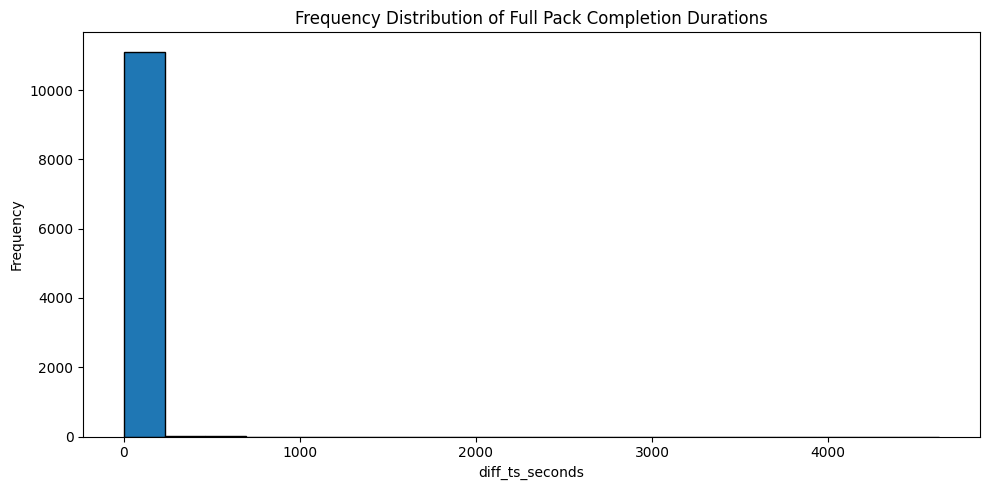

In [25]:
# --- visualize recurring cycle durations ---
plt.figure(figsize=(10,5))
plt.hist(pack_complete_intervals_df.diff_ts_seconds, bins=20, edgecolor='black')
# plt.hist(pack_complete_intervals_df[pack_complete_intervals_df.diff_ts_seconds>300].diff_ts_seconds, bins=20, edgecolor='black')
plt.title("Frequency Distribution of Full Pack Completion Durations")
plt.xlabel("diff_ts_seconds")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [26]:
pack_complete_intervals_df[pack_complete_intervals_df.diff_ts_seconds>300]

,start_timestamp,end_timestamp,diff_ts_seconds,seg_observed,gap_since_prev,segment_1_count,segment_2_count,segment_3_count,segment_4_count,segment_5_count,segment_6_count,segment_7_count,segment_8_count,segment_9_count,segment_10_count
1512,2025-10-01 03:29:17.657,2025-10-01 03:38:58.397,580.740,10,1.170,2,2,4,3,4,3,1,5,5,5
1525,2025-10-01 03:41:16.843,2025-10-01 03:49:55.917,519.074,10,1.126,3,3,1,2,4,3,2,2,2,1
1543,2025-10-01 03:51:59.527,2025-10-01 04:16:57.337,1497.810,10,2.030,4,2,4,4,4,3,2,3,3,1
1922,2025-10-01 05:39:05.962,2025-10-01 05:44:22.659,316.697,10,1.880,6,6,6,2,6,1,4,3,4,6
3661,2025-10-01 10:15:38.672,2025-10-01 10:22:06.324,387.652,10,2.179,4,2,3,4,5,2,2,4,1,4
5750,2025-10-01 14:14:19.303,2025-10-01 15:31:30.329,4631.026,10,1.040,1,2,2,1,2,1,1,2,2,2
7757,2025-10-01 20:04:40.608,2025-10-01 20:21:44.844,1024.236,10,2.259,5,2,4,6,4,4,1,3,2,1
7760,2025-10-01 20:22:29.504,2025-10-01 20:31:57.810,568.306,10,1.020,3,1,5,3,6,5,1,3,3,2
10327,2025-10-02 07:13:04.784,2025-10-02 07:26:36.491,811.707,10,2.580,5,6,6,1,4,4,4,2,2,4
11036,2025-10-02 21:25:44.645,2025-10-02 21:31:52.706,368.061,10,6.380,9,15,16,15,25,21,14,1,14,22


In [27]:
mask = pack_complete_intervals_df["diff_ts_seconds"] > 500
high_gap_times = pack_complete_intervals_df.loc[mask, ["start_timestamp", "end_timestamp"]]

# Inspect CAN density and timestamps in those windows
for _, row in high_gap_times.iterrows():
    window = df_cpo100[(df_cpo100["timestamp"] >= row["start_timestamp"]) &
                       (df_cpo100["timestamp"] <= row["end_timestamp"])]
    print(row["start_timestamp"], "–", row["end_timestamp"], f"({len(window)} records), duration: {row['end_timestamp'] - row['start_timestamp']}")
    print(window[["timestamp", "number_of_can_ids", "percentage_of_can_ids"]].describe())


2025-10-01 03:29:17.657000 – 2025-10-01 03:38:58.397000 (18 records), duration: 0 days 00:09:40.740000
                           timestamp  number_of_can_ids  percentage_of_can_ids
count                             18          18.000000              18.000000
mean   2025-10-01 03:33:36.725888768          22.333333              17.048346
min       2025-10-01 03:29:17.657000          17.000000              12.977099
25%    2025-10-01 03:29:22.111500032          21.000000              16.030533
50%    2025-10-01 03:29:26.556999936          22.000000              16.793894
75%    2025-10-01 03:38:53.841999872          23.750000              18.129772
max       2025-10-01 03:38:58.397000          28.000000              21.374044
std                              NaN           2.890146               2.206218
2025-10-01 03:41:16.843000 – 2025-10-01 03:49:55.917000 (152 records), duration: 0 days 00:08:39.074000
                           timestamp  number_of_can_ids  percentage_of_can_ids
cou

In [28]:
# Check fraction of NaN temperature sensors during high diff_ts periods
window_stats = []
for _, row in high_gap_times.iterrows():
    window = df_cpo100[(df_cpo100["timestamp"] >= row["start_timestamp"]) &
                       (df_cpo100["timestamp"] <= row["end_timestamp"])]
    null_fraction = window[[c for c in df_cpo100.columns if c.startswith("pack_temperature")]].isna().mean().mean()
    window_stats.append((row["start_timestamp"], row["end_timestamp"], null_fraction))
pd.DataFrame(window_stats, columns=["start_ts", "end_ts", "mean_null_fraction"])


,start_ts,end_ts,mean_null_fraction
0,2025-10-01 03:29:17.657,2025-10-01 03:38:58.397,0.811111
1,2025-10-01 03:41:16.843,2025-10-01 03:49:55.917,0.984868
2,2025-10-01 03:51:59.527,2025-10-01 04:16:57.337,0.823529
3,2025-10-01 14:14:19.303,2025-10-01 15:31:30.329,0.999614
4,2025-10-01 20:04:40.608,2025-10-01 20:21:44.844,0.831579
5,2025-10-01 20:22:29.504,2025-10-01 20:31:57.810,0.831579
6,2025-10-02 07:13:04.784,2025-10-02 07:26:36.491,0.920833


In [29]:
window[["timestamp", "vehiclereadycondition", "gun_connection_status", "ignitionstatus"]]

,timestamp,vehiclereadycondition,gun_connection_status,ignitionstatus
14561,2025-10-02 07:26:03.251,1.0,0.0,1.0
14562,2025-10-02 07:26:12.431,1.0,0.0,NaN
14563,2025-10-02 07:26:28.351,1.0,0.0,1.0
14564,2025-10-02 07:26:33.531,1.0,0.0,1.0
14570,2025-10-02 07:25:52.951,1.0,0.0,1.0
14571,2025-10-02 07:26:30.251,1.0,0.0,1.0
14575,2025-10-02 07:25:50.371,1.0,0.0,1.0
14576,2025-10-02 07:26:14.731,1.0,0.0,1.0
14577,2025-10-02 07:26:17.731,1.0,0.0,1.0
14578,2025-10-02 07:26:20.791,1.0,0.0,1.0


In [30]:
def classify_gap(row):
    window = df_cpo100[(df_cpo100["timestamp"] >= row.start_timestamp) &
                       (df_cpo100["timestamp"] <= row.end_timestamp)]
    null_rate = window.filter(like="pack_temperature").isna().mean().mean()
    can_ids_mean = window["number_of_can_ids"].mean() if "number_of_can_ids" in window else np.nan
    veh_ready = window["vehiclereadycondition"].mode().iloc[0] if "vehiclereadycondition" in window else np.nan
    gun_conn = window["gun_connection_status"].mode().iloc[0] if "gun_connection_status" in window else np.nan
    return pd.Series({"mean_null_rate": null_rate,
                      "mean_can_ids": can_ids_mean,
                      "veh_ready_mode": veh_ready,
                      "gun_conn_mode": gun_conn})

mask = pack_complete_intervals_df["diff_ts_seconds"] > 500
diagnosis = pack_complete_intervals_df.loc[mask].apply(classify_gap, axis=1)
display(diagnosis)


,mean_null_rate,mean_can_ids,veh_ready_mode,gun_conn_mode
1512,0.811111,22.333333,0.0,1.0
1525,0.984868,3.651316,0.0,0.0
1543,0.823529,18.764706,0.0,0.0
5750,0.999614,2.063435,0.0,0.0
7757,0.831579,22.947368,1.0,0.0
7760,0.831579,23.105263,1.0,0.0
10327,0.920833,19.270833,1.0,0.0


In [31]:
df_cpo100.bmslifesignal.describe()

count    106113.000000
mean        127.263342
std          73.917081
min           0.000000
25%          63.000000
50%         127.000000
75%         191.000000
max         255.000000
Name: bmslifesignal, dtype: float64

In [32]:
# assume: df_cpo100 already loaded with 'bmslifesignal' and timestamp columns
# and pack_complete_intervals_df holds the intervals

mask = pack_complete_intervals_df["diff_ts_seconds"] > 500
high_gap_intervals = pack_complete_intervals_df.loc[mask, ["start_timestamp", "end_timestamp"]]

def analyze_bms_activity(row):
    # slice main dataframe for that interval
    window = df_cpo100[(df_cpo100["timestamp"] >= row.start_timestamp) &
                       (df_cpo100["timestamp"] <= row.end_timestamp)]
    
    # compute basic stats
    n_records = len(window)
    can_mean = window["number_of_can_ids"].mean() if "number_of_can_ids" in window else np.nan
    null_rate = window.filter(like="pack_temperature").isna().mean().mean()
    
    if "bmslifesignal" in window:
        unique_vals = window["bmslifesignal"].nunique(dropna=True)
        min_val = window["bmslifesignal"].min()
        max_val = window["bmslifesignal"].max()
        diff_val = (max_val - min_val) if pd.notna(min_val) and pd.notna(max_val) else np.nan
    else:
        unique_vals = min_val = max_val = diff_val = np.nan

    # simple heuristic classification
    if unique_vals <= 1 or pd.isna(unique_vals):
        status = "BMS heartbeat missing / frozen"
    elif diff_val < 5:
        status = "BMS sluggish / intermittent"
    else:
        status = "BMS active but CAN/TMS mute"

    return pd.Series({
        "n_records": n_records,
        "mean_CAN_IDs": can_mean,
        "mean_null_rate": null_rate,
        "bms_unique_vals": unique_vals,
        "bms_min": min_val,
        "bms_max": max_val,
        "bms_diff": diff_val,
        "status_inference": status
    })

bms_diagnostics = high_gap_intervals.apply(analyze_bms_activity, axis=1)
pd.set_option("display.max_colwidth", None)
display(bms_diagnostics)


,n_records,mean_CAN_IDs,mean_null_rate,bms_unique_vals,bms_min,bms_max,bms_diff,status_inference
1512,18,22.333333,0.811111,18,1.0,178.0,177.0,BMS active but CAN/TMS mute
1525,152,3.651316,0.984868,11,2.0,215.0,213.0,BMS active but CAN/TMS mute
1543,17,18.764706,0.823529,12,2.0,166.0,164.0,BMS active but CAN/TMS mute
5750,4146,2.063435,0.999614,11,1.0,35.0,34.0,BMS active but CAN/TMS mute
7757,19,22.947368,0.831579,19,71.0,181.0,110.0,BMS active but CAN/TMS mute
7760,19,23.105263,0.831579,18,57.0,149.0,92.0,BMS active but CAN/TMS mute
10327,48,19.270833,0.920833,32,2.0,253.0,251.0,BMS active but CAN/TMS mute


In [33]:
# 0. Parse time, sort
df = df_cpo100.copy()
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.sort_values("timestamp").reset_index(drop=True)

# 1. Find voltage columns (1..380)
volt_cols = sorted(
    [c for c in df.columns if c.startswith("pack_cellvoltage_")],
    key=lambda x: int(x.split("_")[-1])
)
n_cells = len(volt_cols)
assert n_cells >= 1, "No voltage columns found."

# Per-column missing rate
voltage_missing_rate = df[volt_cols].isna().mean().to_frame("missing_rate").sort_values("missing_rate", ascending=False)

# Per-row valid count
df["volt_valid_count"] = df[volt_cols].notna().sum(axis=1)
df["volt_null_frac"] = 1 - (df["volt_valid_count"] / n_cells)

# Correlate coverage with bus health
coverage_corr = df[["volt_valid_count"]].join(
    df[[c for c in ["number_of_can_ids","percentage_of_can_ids","vehiclereadycondition","gun_connection_status"] if c in df]]
).corr()["volt_valid_count"].sort_values(ascending=False)

# Co-missing (pairwise) — summarize strongest pairs (heavy matrix; we don’t print full)
null_mat = df[volt_cols].isna().astype(int)
# For speed, sample rows if huge
sample_idx = np.linspace(0, len(df)-1, min(4000, len(df))).astype(int)
null_corr = null_mat.iloc[sample_idx].corr()
strong_comiss_pairs = (
    null_corr.where(~np.eye(n_cells, dtype=bool))
             .stack().reset_index()
             .rename(columns={"level_0":"cell_a","level_1":"cell_b",0:"null_corr"})
             .query("null_corr > 0.7")
             .sort_values("null_corr", ascending=False)
)
print("Voltage Missing Rate (Top 10):")
display(voltage_missing_rate.head(10))

# Dead columns (all NaN)
dead_cells = [c for c in volt_cols if df[c].notna().sum()==0]

# Stuck / flatliners: very low std or very few unique values
def is_stuck(series, std_eps=1e-4, uniq_max=3):
    s = series.dropna()
    return (s.std(skipna=True) < std_eps) or (s.nunique(dropna=True) <= uniq_max)

stuck_cells = [c for c in volt_cols if is_stuck(df[c], std_eps=1e-4, uniq_max=2)]

# Out-of-range values (typical Li-ion sanity: 2.5V..4.4V ; tune to your chemistry)
low_thresh, high_thresh = 2.5, 4.4
oo_range_counts = ((df[volt_cols] < low_thresh) | (df[volt_cols] > high_thresh)).sum().sort_values(ascending=False)
out_of_range_cells = oo_range_counts[oo_range_counts > 0]
print(f"Dead Cells: {dead_cells}")
print(f"Stuck Cells: {stuck_cells}")
print("Out-of-Range Cells (count > 0):")
display(out_of_range_cells)

Voltage Missing Rate (Top 10):


,missing_rate
pack_cellvoltage_277,0.980798
pack_cellvoltage_278,0.980798
pack_cellvoltage_279,0.980798
pack_cellvoltage_280,0.980798
pack_cellvoltage_180,0.980781
pack_cellvoltage_179,0.980781
pack_cellvoltage_178,0.980781
pack_cellvoltage_177,0.980781
pack_cellvoltage_285,0.980772
pack_cellvoltage_288,0.980772


Dead Cells: []
Stuck Cells: []
Out-of-Range Cells (count > 0):


Series([], dtype: int64)

In [34]:
# Robust per-timestamp stats (ignore dead/stuck if you want stricter hygiene)
active_cells = [c for c in volt_cols if c not in set(dead_cells) | set(stuck_cells)]

df["pack_v_min"] = df[active_cells].min(axis=1)
df["pack_v_max"] = df[active_cells].max(axis=1)
df["pack_v_mean"] = df[active_cells].mean(axis=1)
df["pack_v_median"] = df[active_cells].median(axis=1)
df["pack_v_std"] = df[active_cells].std(axis=1)
df["pack_v_iqr"] = df[active_cells].quantile(0.75, axis=1) - df[active_cells].quantile(0.25, axis=1)

# Imbalance signal
df["pack_v_imbalance"] = df["pack_v_max"] - df["pack_v_min"]

# Top-K worst cells at each timestamp (optional, heavier)
# Example: count how often each cell is the min or max
min_hits = (df[active_cells].eq(df["pack_v_min"], axis=0)).sum().sort_values(ascending=False)
max_hits = (df[active_cells].eq(df["pack_v_max"], axis=0)).sum().sort_values(ascending=False)

In [35]:
print("Top Cells as Minimum Voltage:")
display(min_hits.head(10))
print("Top Cells as Maximum Voltage:")
display(max_hits.head(10))

Top Cells as Minimum Voltage:


pack_cellvoltage_333    1453
pack_cellvoltage_256    1437
pack_cellvoltage_112    1420
pack_cellvoltage_4      1398
pack_cellvoltage_61     1296
pack_cellvoltage_197    1271
pack_cellvoltage_320    1257
pack_cellvoltage_149    1237
pack_cellvoltage_86     1228
pack_cellvoltage_101    1211
dtype: int64

Top Cells as Maximum Voltage:


pack_cellvoltage_2      1596
pack_cellvoltage_140    1467
pack_cellvoltage_64     1422
pack_cellvoltage_234    1358
pack_cellvoltage_176    1343
pack_cellvoltage_186    1284
pack_cellvoltage_260    1282
pack_cellvoltage_28     1224
pack_cellvoltage_352    1217
pack_cellvoltage_54     1204
dtype: int64

In [36]:
def stratify(df):
    # heuristics: tune if you have a definitive "mode" column
    drive = df.query("vehiclereadycondition == 1") if "vehiclereadycondition" in df else df.iloc[0:0]
    charge = df.query("gun_connection_status == 1") if "gun_connection_status" in df else df.iloc[0:0]
    idle = df.loc[df.index.difference(drive.index.union(charge.index))]

    def summarize(group):
        if group.empty: 
            return pd.Series(dtype=float)
        return pd.Series({
            "n_rows": len(group),
            "imbalance_mean": group["pack_v_imbalance"].mean(),
            "imbalance_95p": group["pack_v_imbalance"].quantile(0.95),
            "mean_cell_v": group["pack_v_mean"].mean(),
            "std_cell_v": group["pack_v_std"].mean()
        })
    return pd.DataFrame({
        "drive": summarize(drive),
        "charge": summarize(charge),
        "idle": summarize(idle)
    })

state_summary = stratify(df)
print("Stratified Battery Voltage Summary:")
display(state_summary)

Stratified Battery Voltage Summary:


,drive,charge,idle
n_rows,88099.000000,17543.000000,10234.000000
imbalance_mean,0.002908,0.004993,0.004536
imbalance_95p,0.008000,0.013000,0.013750
mean_cell_v,3.297415,3.389658,3.341761
std_cell_v,0.001048,0.001480,0.001512


In [37]:
# Robust Z via MAD against per-timestamp median
def robust_z(x):
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med)) or 1e-9
    return 0.6745 * (x - med) / mad

# Flag cells whose |robust_z| > 3 at any time
robz = df[active_cells].apply(robust_z, axis=1)  # row-wise
outlier_mask = (np.abs(robz) > 3)
outlier_counts = outlier_mask.sum().sort_values(ascending=False)
persistent_outliers = outlier_counts[outlier_counts > 0]
print("Persistent Voltage Outlier Cells (|robust_z| > 3):")
display(persistent_outliers)

/var/folders/zf/hbscm11n3x7ckch1nd3tg2nh0000gn/T/ipykernel_6671/3687822448.py:3: RuntimeWarning: All-NaN slice encountered
  med = np.nanmedian(x)
/var/folders/zf/hbscm11n3x7ckch1nd3tg2nh0000gn/T/ipykernel_6671/3687822448.py:4: RuntimeWarning: All-NaN slice encountered
  mad = np.nanmedian(np.abs(x - med)) or 1e-9


Persistent Voltage Outlier Cells (|robust_z| > 3):


pack_cellvoltage_333    670
pack_cellvoltage_15     664
pack_cellvoltage_112    644
pack_cellvoltage_260    636
pack_cellvoltage_140    629
pack_cellvoltage_123    589
pack_cellvoltage_176    567
pack_cellvoltage_352    562
pack_cellvoltage_245    561
pack_cellvoltage_2      555
pack_cellvoltage_256    552
pack_cellvoltage_197    550
pack_cellvoltage_149    544
pack_cellvoltage_234    535
pack_cellvoltage_150    532
pack_cellvoltage_117    520
pack_cellvoltage_101    519
pack_cellvoltage_64     510
pack_cellvoltage_225    505
pack_cellvoltage_4      504
pack_cellvoltage_28     503
pack_cellvoltage_183    503
pack_cellvoltage_224    492
pack_cellvoltage_258    489
pack_cellvoltage_276    486
pack_cellvoltage_186    485
pack_cellvoltage_320    473
pack_cellvoltage_246    461
pack_cellvoltage_29     457
pack_cellvoltage_61     452
pack_cellvoltage_22     448
pack_cellvoltage_86     446
pack_cellvoltage_54     435
pack_cellvoltage_261    433
pack_cellvoltage_16     429
pack_cellvoltage_341

In [38]:
# Progressive fill cycles for voltage
received = set()
start_ts = None
voltage_full_cycles = []

for _, row in df.iterrows():
    ts = row["timestamp"]
    valid_now = [c for c in volt_cols if pd.notna(row[c])]
    if valid_now:
        if start_ts is None:
            start_ts = ts
        received.update(valid_now)
    if len(received) == n_cells:
        voltage_full_cycles.append({
            "start_timestamp": start_ts,
            "end_timestamp": ts,
            "diff_ts_seconds": (ts - start_ts).total_seconds()
        })
        received.clear()
        start_ts = None

voltage_cycles_df = pd.DataFrame(voltage_full_cycles)
if not voltage_cycles_df.empty:
    voltage_cycles_df["gap_since_prev"] = (
        voltage_cycles_df["start_timestamp"] - voltage_cycles_df["end_timestamp"].shift(1)
    ).dt.total_seconds()


In [39]:
voltage_cycles_df.head(10)

,start_timestamp,end_timestamp,diff_ts_seconds,gap_since_prev
0,2025-10-01 00:00:00.776,2025-10-01 00:01:45.596,104.820,NaN
1,2025-10-01 00:01:46.607,2025-10-01 00:03:59.516,132.909,1.011
2,2025-10-01 00:04:00.565,2025-10-01 00:04:59.716,59.151,1.049
3,2025-10-01 00:05:00.796,2025-10-01 00:07:51.136,170.340,1.080
4,2025-10-01 00:07:52.236,2025-10-01 00:11:21.216,208.980,1.100
5,2025-10-01 00:11:23.297,2025-10-01 00:14:36.196,192.899,2.081
6,2025-10-01 00:14:37.216,2025-10-01 00:18:09.464,212.248,1.020
7,2025-10-01 00:18:10.504,2025-10-01 00:19:29.644,79.140,1.040
8,2025-10-01 00:19:30.664,2025-10-01 00:21:56.464,145.800,1.020
9,2025-10-01 00:21:57.544,2025-10-01 00:24:55.664,178.120,1.080


In [40]:
voltage_cycles_df.diff_ts_seconds.describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99,0.995, 0.999])

count     737.000000
mean      231.964719
std       356.399436
min        37.700000
25%        83.520000
50%       119.896000
75%       178.120000
95%       980.848800
99%      1631.990920
99.5%    1870.729600
99.9%    3092.965960
max      4728.185000
Name: diff_ts_seconds, dtype: float64

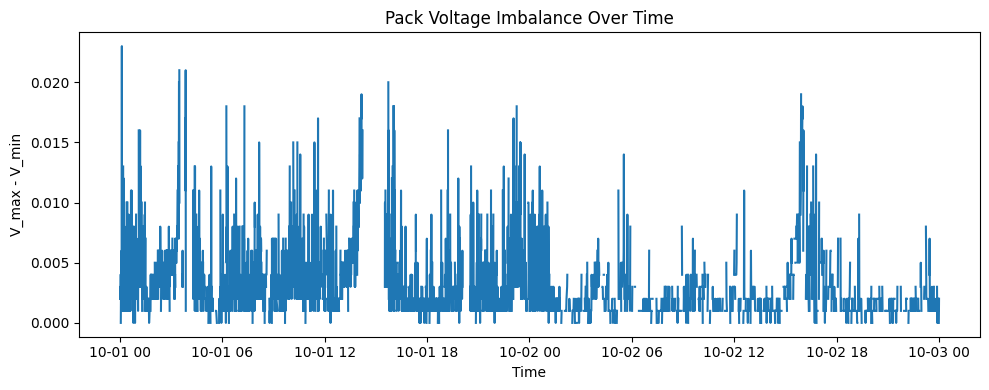

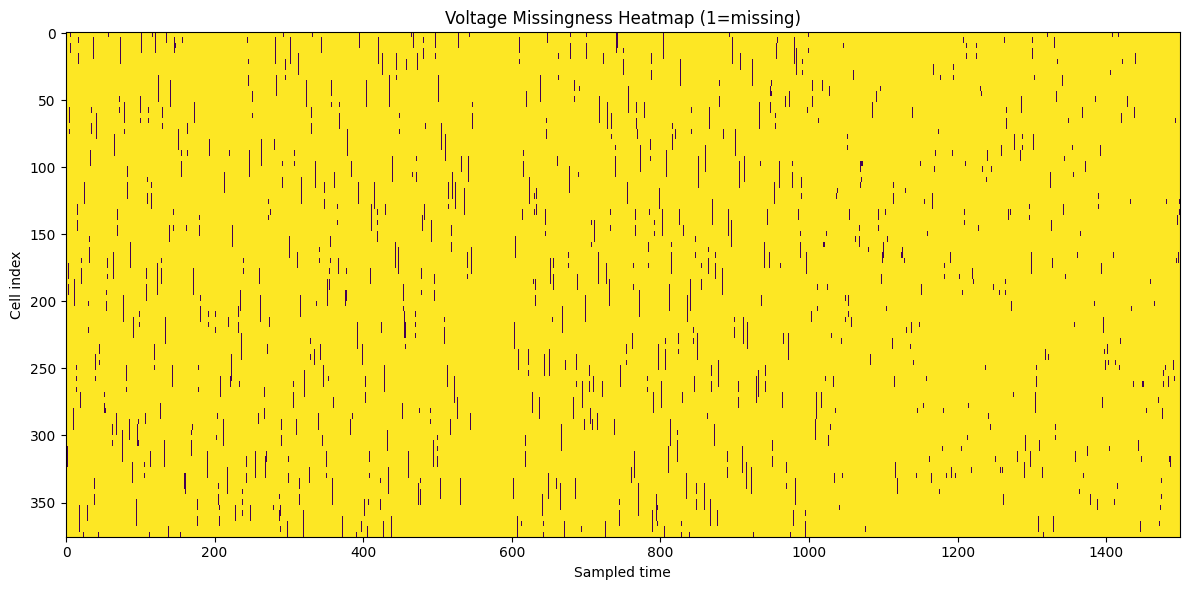

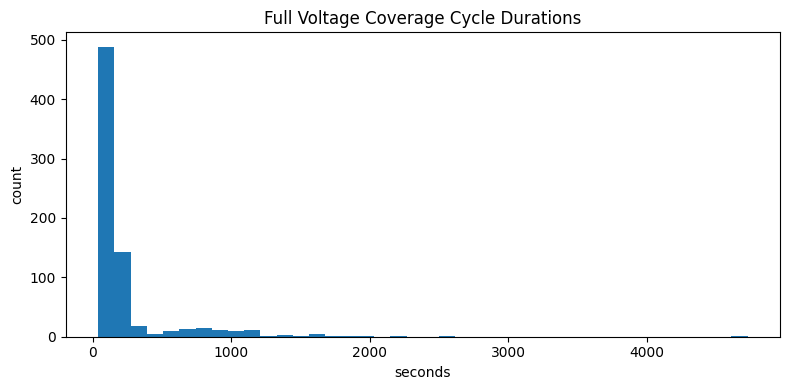

In [41]:
import matplotlib.pyplot as plt

# Imbalance over time (sampled to keep it light)
idx = np.linspace(0, len(df)-1, min(5000, len(df))).astype(int)
plt.figure(figsize=(10,4))
plt.plot(df.iloc[idx]["timestamp"], df.iloc[idx]["pack_v_imbalance"])
plt.title("Pack Voltage Imbalance Over Time")
plt.xlabel("Time"); plt.ylabel("V_max - V_min"); plt.tight_layout(); plt.show()

# Voltage missingness heatmap (sample time)
sidx = np.linspace(0, len(df)-1, min(1500, len(df))).astype(int)
heat = df.iloc[sidx][volt_cols].isna().astype(int).T  # cells x time
plt.figure(figsize=(12,6))
plt.imshow(heat, aspect="auto", interpolation="nearest")
plt.title("Voltage Missingness Heatmap (1=missing)"); plt.xlabel("Sampled time"); plt.ylabel("Cell index"); plt.tight_layout(); plt.show()

# Distribution of full-coverage cycle durations (if computed)
if not voltage_cycles_df.empty:
    plt.figure(figsize=(8,4))
    plt.hist(voltage_cycles_df["diff_ts_seconds"].dropna(), bins=40)
    plt.title("Full Voltage Coverage Cycle Durations")
    plt.xlabel("seconds"); plt.ylabel("count"); plt.tight_layout(); plt.show()


In [ ]:
wait